In [ ]:
%env  WORKDIR=/tmp/vault

# [KV Secret Engine](https://developer.hashicorp.com/vault/tutorials/secrets-management/versioned-kv)

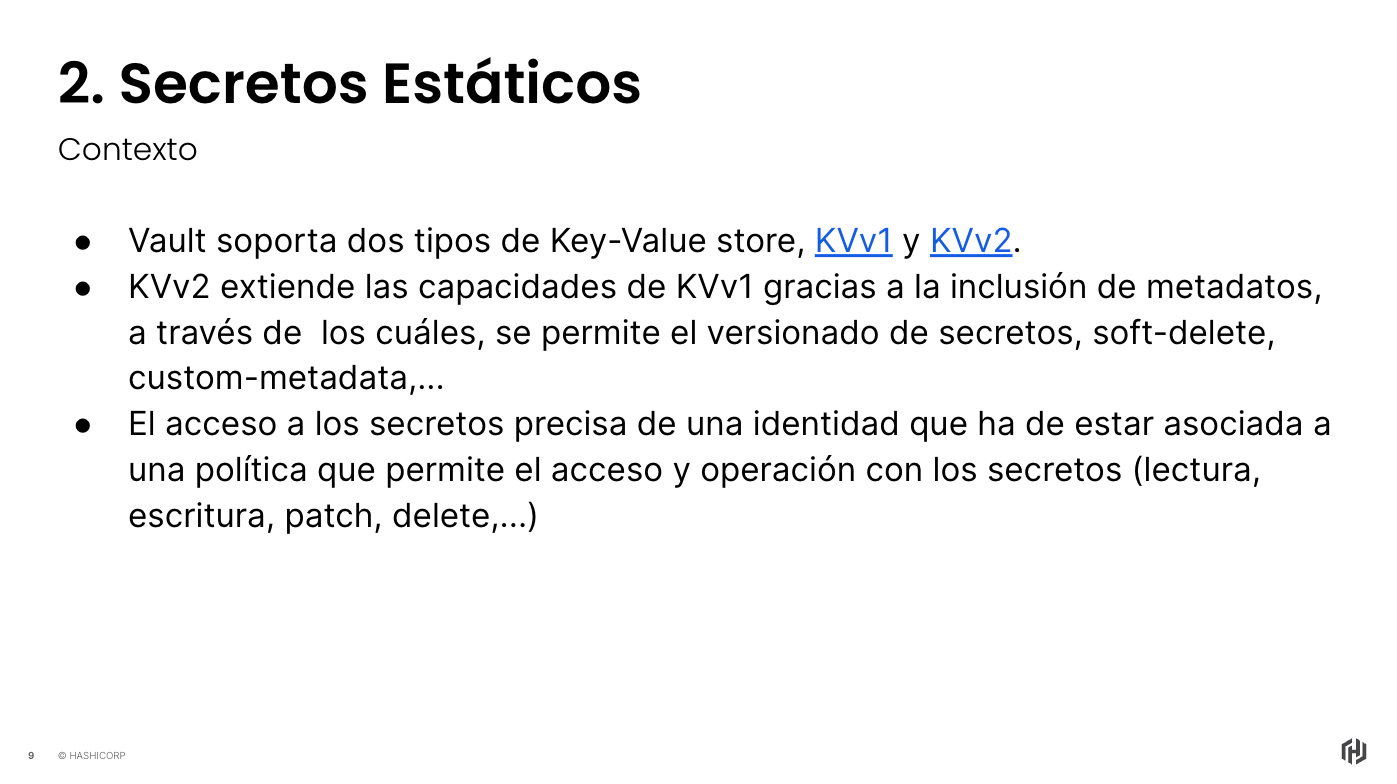

In [ ]:
%%bash
cat $WORKDIR/VAULT_TOKEN.TXT
cat $WORKDIR/VAULT_ADDR.TXT

Update the values of the enviromental values of the following cells based on the output of the previous cell

In [ ]:
%env VAULT_ADDR=https://vault-primary-europe-southwest1-p5fh.josemerchan-313707.gcp.sbx.hashicorpdemo.com:8200
%env VAULT_TOKEN=hvs.GqTsfXwqgl0bK86WbGIfCBZz

In [ ]:
%%bash
vault secrets list -detailed

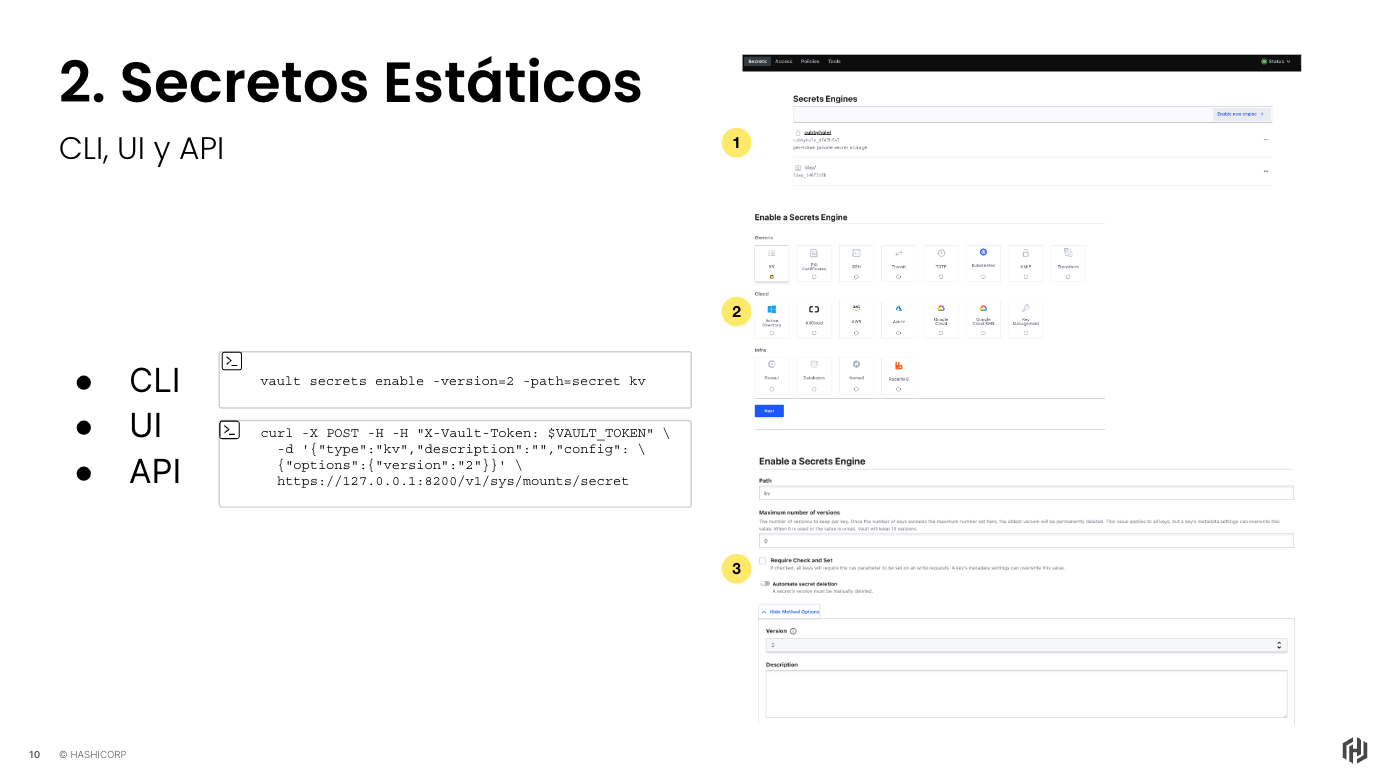

In [ ]:
%%bash
#Enable KVv2
vault secrets enable -version=2 -path=secret kv

## Write Secret via CLI

In [ ]:
%%bash
## Write secret via CLI to Ops path
vault kv put secret/ops/acme1 customer_name="ACME Inc." contact_email="john.smith@acme.com"
vault kv put secret/ops/acme2 customer_name="ACME Inc." contact_email="john.smith@acme.com"
vault kv put secret/ops/acme3 customer_name="ACME Inc." contact_email="john.smith@acme.com"

# Diferenciando un secreto de un "directorio"
vault kv put secret/ops       customer_name="ACME Inc." contact_email="john.smith@acme.com"

In [ ]:
%%bash
## Write secret via CLI to Dev path
vault kv put secret/dev/acme1 customer_name="Vault Inc." contact_email="jenny.smith@vault.com"
vault kv put secret/dev/acme2 customer_name="Vault Inc." contact_email="jenny.smith@vault.com"
vault kv put secret/dev/acme3 customer_name="Vault Inc." contact_email="jenny.smith@vault.com"

## Write a secret via API

In [ ]:
%%bash 
## Write secret via API
## Include a new version of the secret
cat > $WORKDIR/secret.json <<EOF
{
  "data": {
    "name": "ACME Inc.",
    "contact_email": "jose@acme.com"
  }
}
EOF

## Unlike the kv put, here we have to set the api to v1 and go to the data endpoint
## The result is a new version of the existing secret
curl -s -k --header "X-Vault-Token: $VAULT_TOKEN" --request POST --data @$WORKDIR/secret.json $VAULT_ADDR/v1/secret/data/ops/acme | jq


## Add custom metadata to secret via API

In [ ]:
%%bash
## We can add custom metadata
tee $WORKDIR/payload_metadata.json <<EOF
{
  "custom_metadata": {
    "Membership": "Platinum",
    "Region": "US West"
  }
}
EOF
## Request goes to the metadata and not data endpoint
curl -s -k --header "X-Vault-Token: $VAULT_TOKEN" --request POST --data @$WORKDIR/payload_metadata.json $VAULT_ADDR/v1/secret/metadata/ops/acme

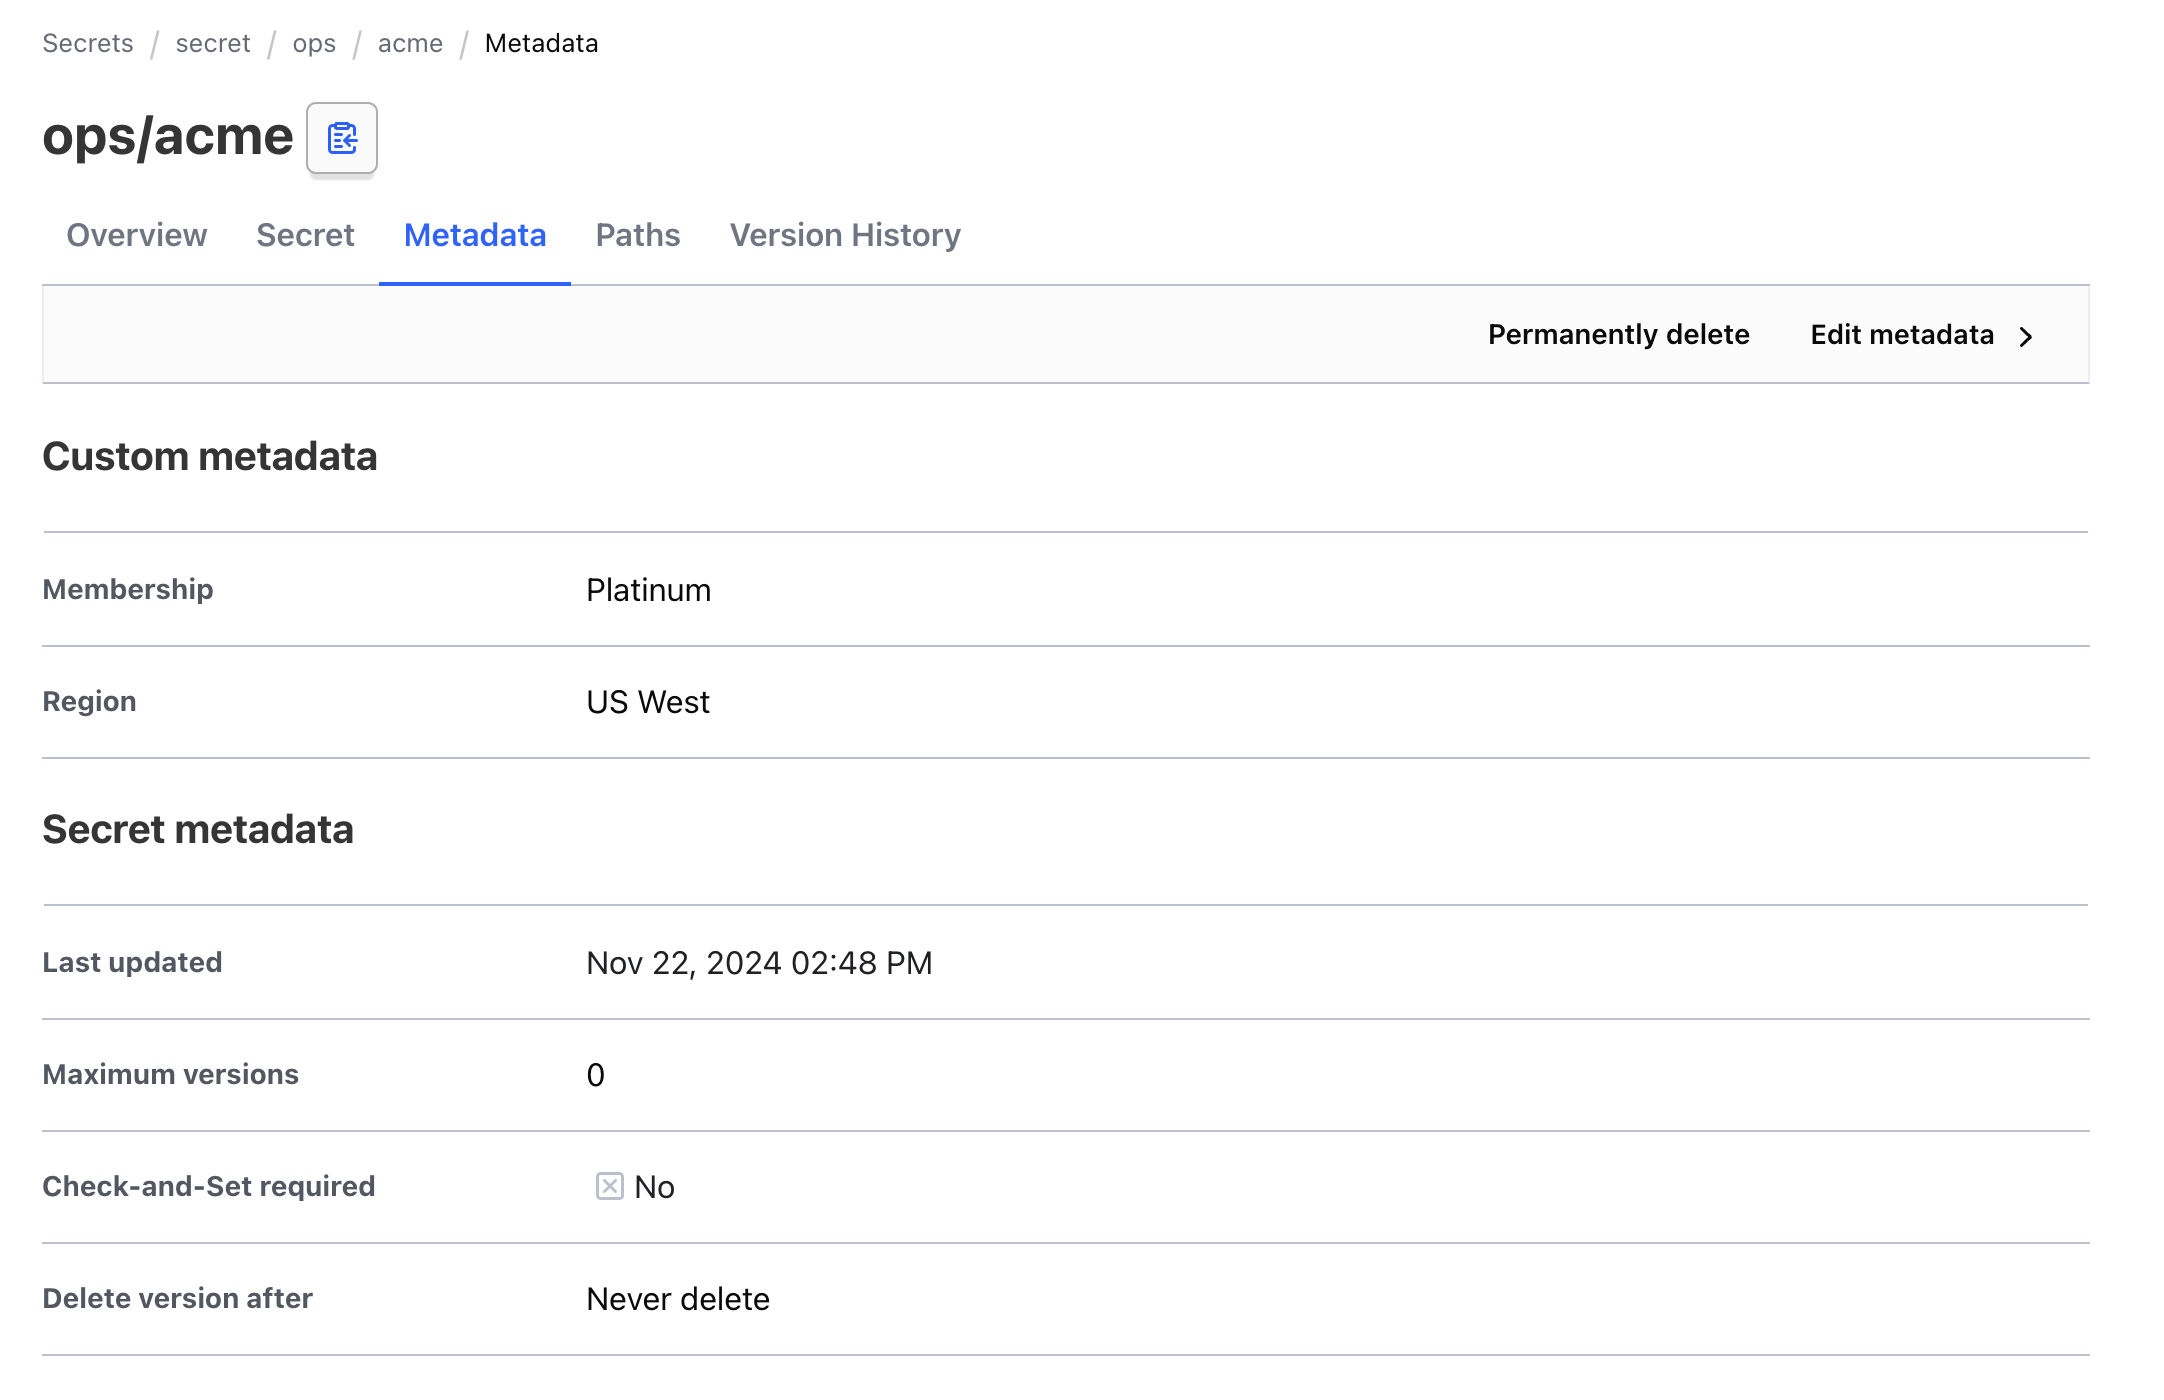

# Read a Secret

## Via CLI

In [ ]:
! vault kv get secret/ops

## Via API

In [ ]:
## Read Secret Data
! curl -s -k --header "X-Vault-Token: $VAULT_TOKEN" --request GET $VAULT_ADDR/v1/secret/data/ops/acme | jq -r .

## Read Metadata
! echo "Metadata only"
! curl -s -k --header "X-Vault-Token: $VAULT_TOKEN" --request GET $VAULT_ADDR/v1/secret/metadata/ops/acme | jq -r .

# Now let's check secret sync

### activate secret sync

In [ ]:
! vault write -f sys/activation-flags/secrets-sync/activate

### run terraform
We are going to create another KVv2 Secret engine with three different secrets and sync those to GCP Secret Manager

In [ ]:
! terraform apply -auto-approve -var-file=variables.tfvars

After the `terraform apply` we can see the following
* On Vault UI:
  * Destinations
  
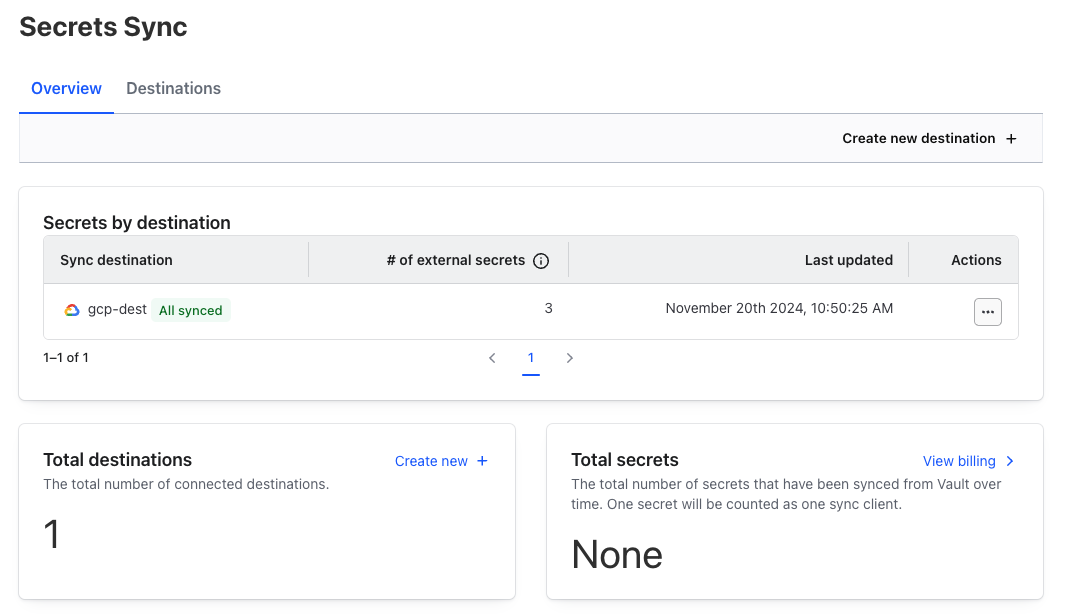

  * Secrets Sync on the GCP Destination
  
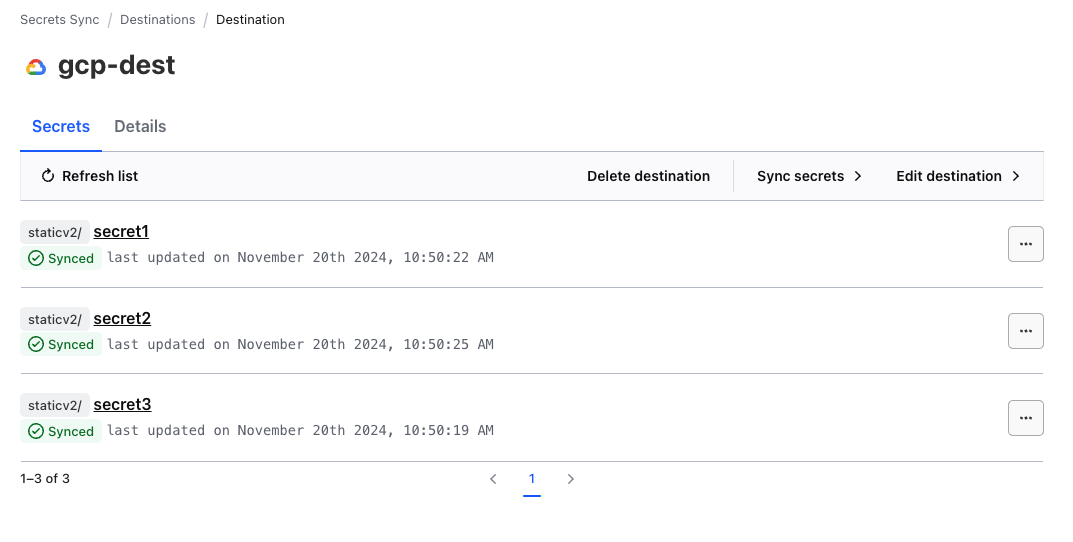

You can see the secrets being synced in GCP Secret Manager: [https://console.cloud.google.com/security/secret-manager](https://console.cloud.google.com/security/secret-manager)

* On GCP Console:
  
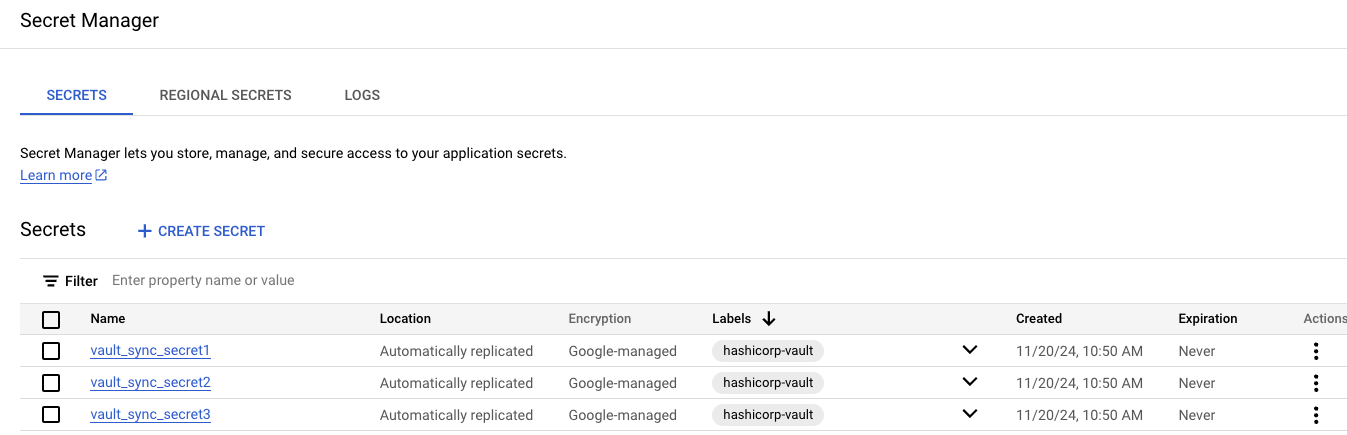

If we update a secret in Vault we get a new version on GCP

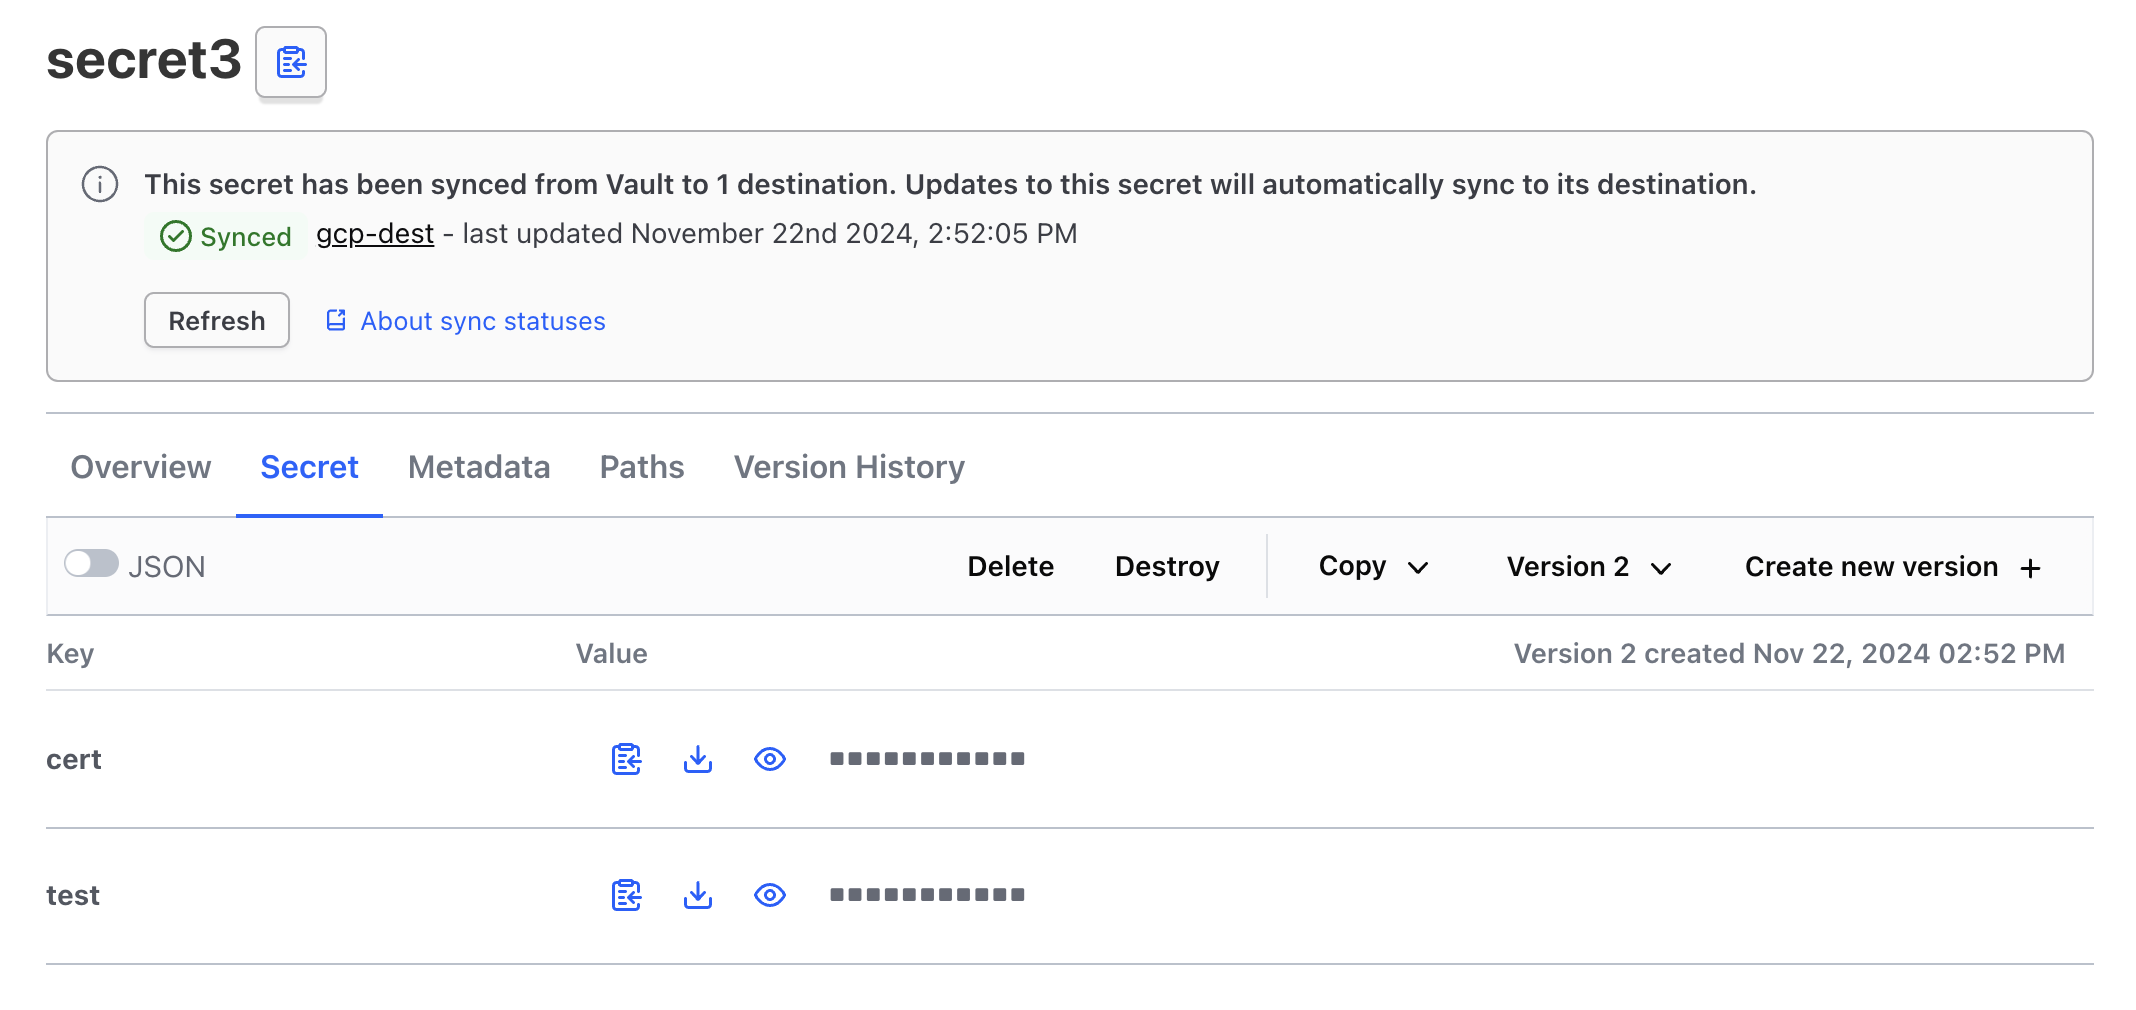

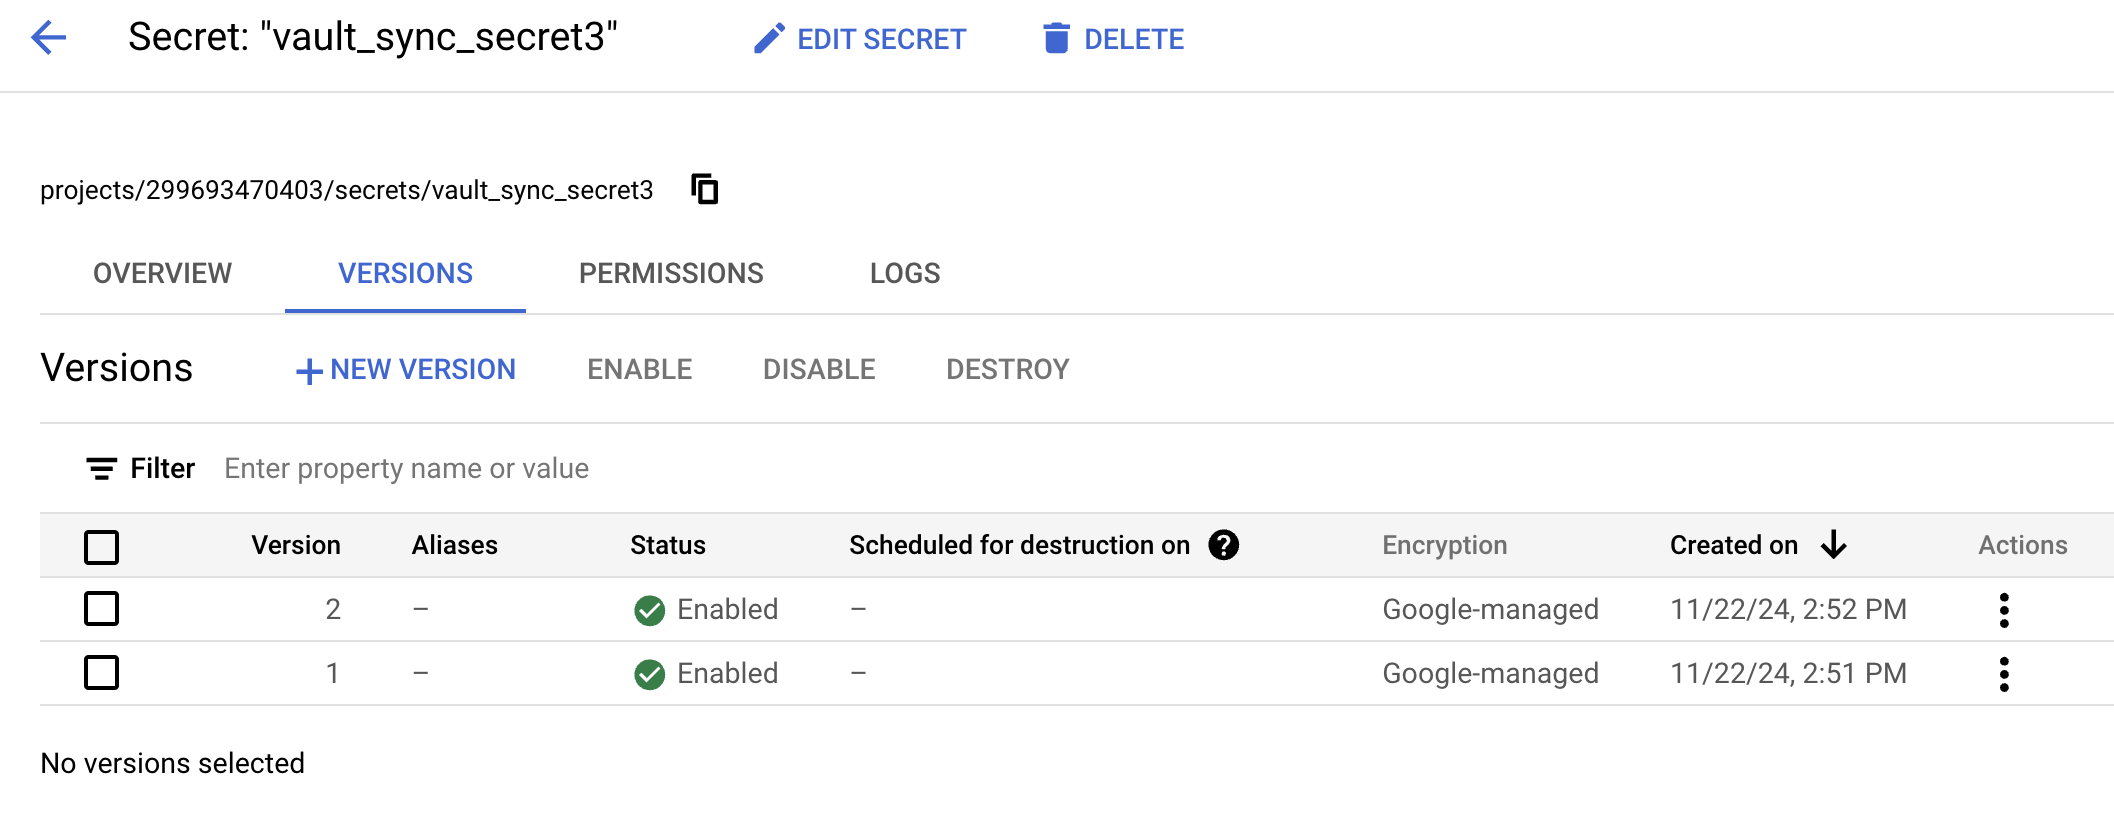

# Clean UP

In [ ]:
%%bash
vault secrets disable secret
terraform destroy -auto-approve -var-file=variables.tfvars
vault write -f sys/activation-flags/secrets-sync/activate